# Identifying Fraud from Enron Data

This project will use machine learning to attempt to identify persons of interest from the Enron financial scandel. Persons of Interest (POIs) were defined at the onset by Udacity using resource created by USA Today <cite data-cite="6112171/BAJ6H3FC"></cite>. 

Two data resources were identified by Udacity for identifying POIs. The first is the Enron Email Datset maintained by Carnegie Mellon University <cite data-cite="6112171/GLPDFEY4"></cite>. The email dataset contains a corpus of close to 500,000 email messages from Enron's servers. The second is a dataset created by Udacity with a collection of useful information for the task. It contains both financial features as well as aggregate information about the email dataset. 

Machine learning excels at this type of task because it can be used to process large amounts of information in a way that would be time consuming if done by hand. Machine learning algorithms use statistical methods to *learn* from data and can then make inferences based on the relationships they have found. Although developing the algorithms takes considerable amount of care and effort in itself, when completed they can be used to process the entire email dataset within minutes.

## Data Exploration
The data was loaded into a pandas dataframes to simplify exploration and visualization.

In [23]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Open the dataset for exploration
with open('final_project_dataset.pkl', 'r') as data_file:
    udacity_data_dict = pickle.load(data_file)

# Load the into a DataFrame, transposed so that columns are the features
udacity_data = pd.DataFrame(udacity_data_dict).T

udacity_data.shape

(146, 21)

There are 146 entries in the dataset and 21 features.

In [24]:
udacity_data['poi'].value_counts()

False    128
True      18
Name: poi, dtype: int64

18 (12%) of the entries are identified as persons of interest.

I decided to separate the dataset into two data frames for exploration because of its split nature. The financial information came from a document attributed to Findlaw.com. Wheras the email information was compiled by aggregating information form the Enron Email corpus. For this reason it made sense to divide the data when looking for trends and similarities between the features.

In [25]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances','bonus',
                      'restricted_stock_deferred', 'deferred_income', 'total_stock_value',
                      'expenses', 'exercised_stock_options', 'other', 'long_term_incentive',
                      'restricted_stock', 'director_fees']

numeric_email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages',
                           'from_this_person_to_poi', 'shared_receipt_with_poi']
text_email_features = ['email_address']

# Separate the features into 2 dataframes and convert all of the numeric features
financial_data = udacity_data[financial_features].astype(float)
email_data = udacity_data[numeric_email_features].astype(float)

# Non numeric data
email_data[text_email_features] = udacity_data[text_email_features]

# And of course the POI label as a boolean value
financial_data['poi'] = udacity_data['poi'].astype(bool)
email_data['poi'] = udacity_data['poi'].astype(bool)

Records should be dropped for any persons for which there is no relevant information. Because the data is split this step can be done separately for each dataframe.

In [26]:
def drop_all_null(df, important_features):
    """Drop rows with all null features"""
    
    null_filter = df[important_features].isnull().all(axis=1)
    null_index = df.index[null_filter]
    return df.drop(null_index)

financial_data = drop_all_null(financial_data, financial_features)
email_data = drop_all_null(email_data, numeric_email_features)

In [27]:
financial_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 15 columns):
salary                       95 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
loan_advances                4 non-null float64
bonus                        82 non-null float64
restricted_stock_deferred    18 non-null float64
deferred_income              49 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
exercised_stock_options      102 non-null float64
other                        93 non-null float64
long_term_incentive          66 non-null float64
restricted_stock             110 non-null float64
director_fees                17 non-null float64
poi                          145 non-null bool
dtypes: bool(1), float64(14)
memory usage: 17.1+ KB


In [28]:
financial_data.info()
print '%s persons of interest.' % financial_data['poi'].sum()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 15 columns):
salary                       95 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
loan_advances                4 non-null float64
bonus                        82 non-null float64
restricted_stock_deferred    18 non-null float64
deferred_income              49 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
exercised_stock_options      102 non-null float64
other                        93 non-null float64
long_term_incentive          66 non-null float64
restricted_stock             110 non-null float64
director_fees                17 non-null float64
poi                          145 non-null bool
dtypes: bool(1), float64(14)
memory usage: 17.1+ KB
18 persons of interest.


145 entries remain in the financial dataset, of which all 18 persons of interest are still included. All of the fields contain null values.

In [29]:
(financial_data == 0).sum()

salary                         0
deferral_payments              0
total_payments                 0
loan_advances                  0
bonus                          0
restricted_stock_deferred      0
deferred_income                0
total_stock_value              0
expenses                       0
exercised_stock_options        0
other                          0
long_term_incentive            0
restricted_stock               0
director_fees                  0
poi                          127
dtype: int64

However, no fields contain zeros. The original source also states that it includes non-employee entries. Because of the variety of payment types I assumed that missing values were used in lieu of zeros.

In [30]:
financial_data.fillna(0, inplace=True)

In [31]:
email_data.info()
print '%s persons of interest.' % email_data['poi'].sum()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, ALLEN PHILLIP K to WHALLEY LAWRENCE G
Data columns (total 7 columns):
to_messages                86 non-null float64
from_poi_to_this_person    86 non-null float64
from_messages              86 non-null float64
from_this_person_to_poi    86 non-null float64
shared_receipt_with_poi    86 non-null float64
email_address              86 non-null object
poi                        86 non-null bool
dtypes: bool(1), float64(5), object(1)
memory usage: 4.8+ KB
14 persons of interest.


Only 86 entries remain, with 4 of the persons of interest having been removed. None of the fields have null values.

The proportion of POIs in the email subset of the data is 25% higher than the full dataset. One thing to watch out for  will be an estimator that gives weight to missing email data as a sign that the person is a POI. This will be a difficult overfit to control for, because the way the dataset is constructed splitting the data into training and test sets will maintain this proportional difference. To counter this I plan to impute missing data for any email fields included in the final algorithm.

## Outlier Investigation

To search for outliers I used the zscore function from scipy. The function normalizes values as a measurement of standard devations from the mean. This makes it easier to analyze values in context to how far they stand out from the rest of the data.  I created a function to screen for any entries with a zscore above 3 for any feature.

In [32]:
from scipy.stats import zscore

def return_outliers(df):
    """Returns a list of entries with feature zscores over 3"""
    # True if absolute value of zcore greater than 3 for any feature across the row(1) axis
    zscore_filter = df.apply(zscore).abs().gt(3).any(axis=1)
    return df.index[zscore_filter]

fin_outliers = return_outliers(financial_data)

print fin_outliers

Index([u'BHATNAGAR SANJAY', u'LAY KENNETH L', u'TOTAL'], dtype='object')


What immediately sticks out is "TOTAL", which should be removed from the data. This entry prompted me to seach through the Findlaw.com document and financial dataframe index for other unusual items. I also found a travel agency that needed to be removed.

In [33]:
financial_data.drop(['TOTAL', 'THE TRAVEL AGENCY IN THE PARK'], inplace=True)

In [34]:
# Search for outliers again, in case zscore have been changed
fin_outliers = return_outliers(financial_data)
print fin_outliers

Index([u'ALLEN PHILLIP K', u'BELDEN TIMOTHY N', u'BHATNAGAR SANJAY',
       u'BLAKE JR. NORMAN P', u'FREVERT MARK A', u'GRAMM WENDY L',
       u'HANNON KEVIN P', u'HIRKO JOSEPH', u'HORTON STANLEY C',
       u'HUMPHREY GENE E', u'JAEDICKE ROBERT', u'LAVORATO JOHN J',
       u'LAY KENNETH L', u'LEMAISTRE CHARLES', u'MARTIN AMANDA K',
       u'MCCLELLAN GEORGE', u'PAI LOU L', u'RICE KENNETH D', u'SAVAGE FRANK',
       u'SHANKMAN JEFFREY A', u'SKILLING JEFFREY K', u'URQUHART JOHN A',
       u'WAKEHAM JOHN', u'WHITE JR THOMAS E', u'WINOKUR JR. HERBERT S'],
      dtype='object')


With the TOTAL entry removed there are now many more outliers. Plotting the data will help to get a better feel of what's going on.

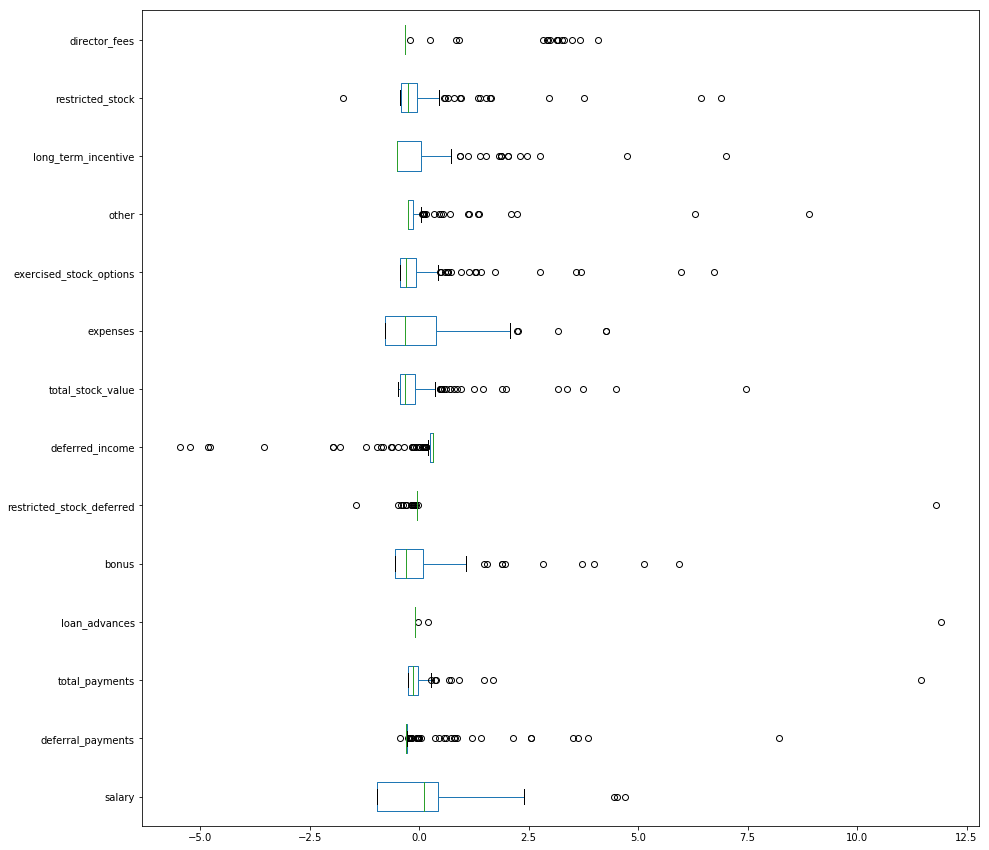

In [35]:
# Create boxplots , using zscore for boxplots to make comparison easier
financial_data[financial_features].apply(zscore).plot.box(
    vert=False, layout=(7,2), figsize=(15,15))
plt.show()

The boxplots show tight interquartile distributions with large amounts of outliers. This makes sense, considering the presense of executives and directors in the data. Their compensation was far beyond the rest of the employess. They also receive unique types of compensation such as restricted stock and director fees which other employees are not paid. These outliers do not represent errors and should be kept.

In [36]:
email_outliers = return_outliers(email_data[numeric_email_features])
print email_outliers
email_data[numeric_email_features].apply(zscore).loc[email_outliers]

Index([u'BECK SALLY W', u'BELDEN TIMOTHY N', u'DELAINEY DAVID W',
       u'KAMINSKI WINCENTY J', u'KEAN STEVEN J', u'LAVORATO JOHN J',
       u'SHAPIRO RICHARD S'],
      dtype='object')


,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
BECK SALLY W,2.041227,0.914800,2.040218,3.465362,1.248486
BELDEN TIMOTHY N,2.304504,1.886212,-0.068180,0.671100,3.708691
DELAINEY DAVID W,0.396917,0.012775,1.344157,5.706803,0.785810
KAMINSKI WINCENTY J,0.986563,-0.276336,7.517465,1.304332,-0.506609
KEAN STEVEN J,4.159514,0.868542,3.360221,3.475413,2.102131
LAVORATO JOHN J,2.019417,5.355540,1.079719,3.716645,2.377858
SHAPIRO RICHARD S,5.092276,0.105290,0.331208,0.238894,2.860168


This is a smaller list than for the financial data, and some outliers are expected. Individuals who regularly contacted POIs are going to stand out from those who didn't because the POIs only make up a small portion of the email corpus.

However, the persons who were identified as outliers for non-POI related fields represent a risk in data leakage. I did some searching and confirmed that these individuals held high level positions at Enron. Kaminski was also reported to have raised objections to Enron's practices prior to its bankruptcy <cite data-cite="6112171/XBR54C3J"></cite>. These individuals could have a higher presense in the email corpus because they were the focus of investigations. This creates a problem where the focus of the investigation could leak in as a factor in identifying POIs.

To counter this I decided to create percentage based representations of the POI features. In this way a classifier cannot know how many total emails are present for a given person in the database.

In [37]:
# Create new features
email_data['from_poi_to_this_person_percent'] = email_data.from_poi_to_this_person / email_data.to_messages
email_data['from_this_person_to_poi_percent'] = email_data.from_this_person_to_poi / email_data.from_messages
email_data['shared_receipt_with_poi_percent'] = email_data.shared_receipt_with_poi / email_data.to_messages

Index([u'DEFFNER JOSEPH M', u'DONAHUE JR JEFFREY M', u'HUMPHREY GENE E'], dtype='object')


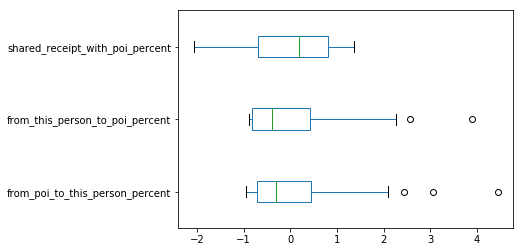

In [38]:
# Visualize the affect
new_email_features = ['from_poi_to_this_person_percent',
                      'from_this_person_to_poi_percent',
                      'shared_receipt_with_poi_percent']
email_outliers = return_outliers(email_data[new_email_features])
print(email_outliers)
email_data[new_email_features].apply(zscore).plot.box(vert=False)
plt.show()

Only three people were found as outliers, none of which were identified as POIs. I plan to test the affects of removing these individuals during the feature and algorithm selection process to see if it increases accuracy.

## Feature Selection

One theory I have is that incidents like the Enron scandal are created by systemic problems within companies. For example, in the case of Enron employee compensation might have been structured in a way that rewarded bad actors. One way to detect structure like this within the data is to use Principal Components Analysis (PCA).

PCA decomposes data into lower dimensions while attempting to retain as much variance as possible <cite data-cite="6112171/SUB22V52"></cite>. If there are trends in the way compensation is structure, PCA might be able to detect them and explain them with fewer features.

Prior to running PCA I removed the total_payments and total_stock_value features. I did this because I was more interested in the variance of the features that composed these values than the total values themselves. I also applied the standard scaler to prevent large compensation items like exectuive stock options from hiding the variance of other forms of compensation.

I created a pipeline to apply scaling and dimensionality reduction, and used a grid search to choose how many principal components to keep <cite data-cite="6112171/GRUQ2GTK"></cite>. I included multiple algoritms in the grid search to ensure that the results weren't impacted by the limitations of the estimator. This also gave me the chance to start thinking about what algorithm would be my final choice for finding POIs.

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score

def plot_pca(fitPCA, labels, n_components=2):
    """Plot the explianed variance ratio and first n compoenent weights"""
    pd.Series(fitPCA.explained_variance_ratio_).cumsum().plot(title='Explained Variance Ratio')
    plt.show()
    for i in range(n_components):
        pd.Series(fitPCA.components_[i], index=labels).plot.bar(title='Component %s feature weight' % i)
        plt.show()

In [49]:
nontotal_features = financial_features[:]
nontotal_features.remove('total_payments')
nontotal_features.remove('total_stock_value')

In [54]:
# Split the finacnial data into test and train datasets
x_train, x_test, y_train, y_test = train_test_split(financial_data[nontotal_features], financial_data['poi'],
                                    test_size=.3, random_state=35)

In [65]:
# Build the pipeline and grid search.

pipe = Pipeline([
    ('scale', MaxAbsScaler()),
    ('reduce_dim', TruncatedSVD()),
    ('classifier', LinearSVC())
])

n_components = np.arange(len(nontotal_features)-1) + 1

param_grid = [
    {
        'decomp__n_components': n_components,
        'classifier': [LinearSVC(), KNeighborsClassifier(), AdaBoostClassifier()]
    }
]

grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1')

In [66]:
# Run the gridsearch
grid.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', MaxAbsScaler(copy=True)), ('decomp', TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)), ('classify', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'classify': [LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), KNeighborsClassifier(algorithm='auto', leaf_size=30, metri..., random_state=None)], 'decomp__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',


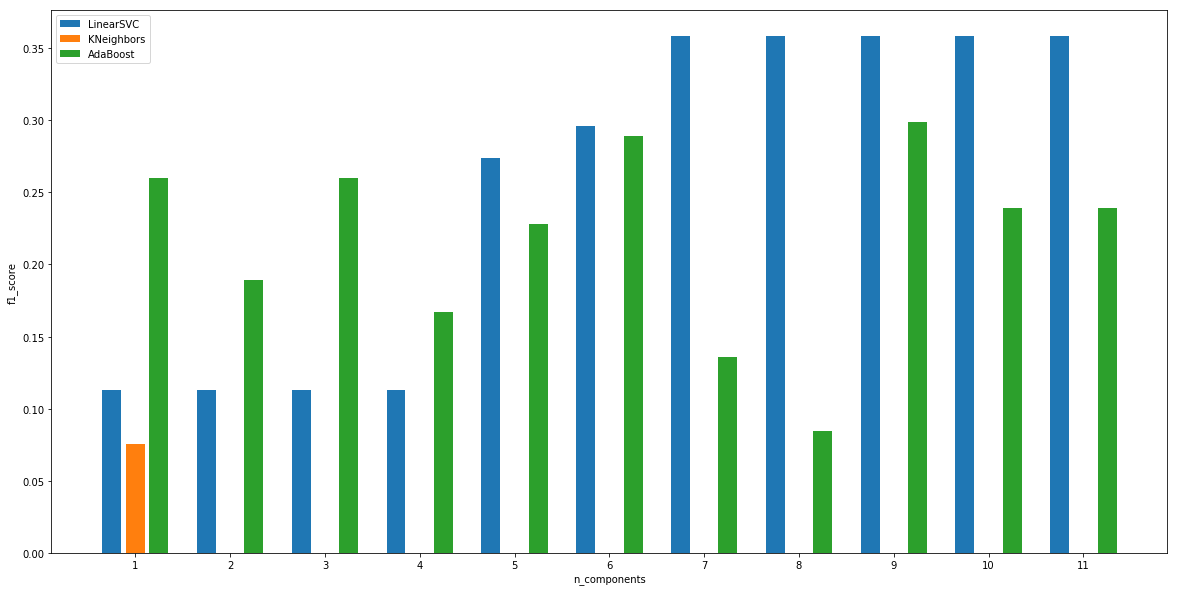

In [67]:
# Plot results

# Labels for the plot legend
classifiers = ['LinearSVC', 'KNeighbors', 'AdaBoost']

# Get scores and reshape them for the zip function
mean_scores = grid.cv_results_['mean_test_score']
mean_scores = mean_scores.reshape(3, -1)

bar_offsets = np.arange(len(n_components)) * 4 + .5

plt.figure(figsize=(20,10))

for i, (classifier, f1_score) in enumerate(zip(classifiers, mean_scores)):
    plt.bar(bar_offsets + i, f1_score, label=classifier)

plt.title('')

plt.xlabel('n_components')
plt.xticks(bar_offsets + 3/2, n_components)

plt.ylabel('f1_score')

plt.legend()
plt.show()

Th

In [ ]:
fit = PCA().fit(x_test)
plot_pca(fit, nontotal_features)

Running a p

In [ ]:
pca = PCA(n_components=4)
financial_components = pca.fit_transform(financial_data[financial_features])

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold()
sel.fit(financial_data[financial_features].values)

## Algorithm Selection

## References
<div class="cite2c-biblio"></div>